In [2]:
!pip install wfdb
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 13.1 MB/s eta 0:00:00a 0:00:01


Found 78 .dat files
Record a09 - Window minutes 0-9
  Labels in window: ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
  Apnea count: 0, Non-apnea count: 10
  Label value (n//2+2): 7 -> Label at index 7: N
------------------------------------------------------------
Record a09 - Window minutes 10-19
  Labels in window: ['A', 'A', 'A', 'A', 'A', 'N', 'N', 'A', 'A', 'A']
  Apnea count: 8, Non-apnea count: 2
  Label value (n//2+2): 7 -> Label at index 7: A
------------------------------------------------------------
Record a09 - Window minutes 20-29
  Labels in window: ['A', 'A', 'A', 'A', 'A', 'N', 'N', 'N', 'N', 'N']
  Apnea count: 5, Non-apnea count: 5
  Label value (n//2+2): 7 -> Label at index 7: N
------------------------------------------------------------
Record a09 - Window minutes 30-39
  Labels in window: ['N', 'N', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A']
  Apnea count: 6, Non-apnea count: 4
  Label value (n//2+2): 7 -> Label at index 7: A
----------------------------------

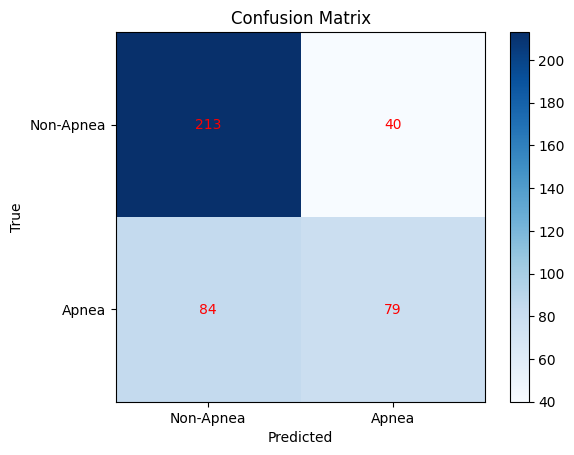


=== Per-sample Evaluation ===

Sample 1/416
  True: Non-Apnea
  Pred: Apnea
  Accuracy: 0.0000
  Sensitivity (Apnea recall): 0.0000
  Specificity (Non-Apnea recall): 0.0000

Sample 2/416
  True: Non-Apnea
  Pred: Non-Apnea
  Accuracy: 1.0000
  Sensitivity (Apnea recall): 0.0000
  Specificity (Non-Apnea recall): 1.0000

Sample 3/416
  True: Apnea
  Pred: Apnea
  Accuracy: 1.0000
  Sensitivity (Apnea recall): 1.0000
  Specificity (Non-Apnea recall): 0.0000

Sample 4/416
  True: Non-Apnea
  Pred: Non-Apnea
  Accuracy: 1.0000
  Sensitivity (Apnea recall): 0.0000
  Specificity (Non-Apnea recall): 1.0000

Sample 5/416
  True: Non-Apnea
  Pred: Apnea
  Accuracy: 0.0000
  Sensitivity (Apnea recall): 0.0000
  Specificity (Non-Apnea recall): 0.0000

Sample 6/416
  True: Non-Apnea
  Pred: Non-Apnea
  Accuracy: 1.0000
  Sensitivity (Apnea recall): 0.0000
  Specificity (Non-Apnea recall): 1.0000

Sample 7/416
  True: Non-Apnea
  Pred: Non-Apnea
  Accuracy: 1.0000
  Sensitivity (Apnea recall): 0.00

In [6]:
# apnea_single_split_eval_n_rule_fixed.py
# Fixed: avoid NaN loss by cleaning inputs, normalization, lower LR, gradient clipping

import os
import wfdb
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    cohen_kappa_score
)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random

# ---------------------------
# Config
# ---------------------------
DATASET_PATH = "/kaggle/input/adult-sleep-apnea/apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0"
WIN_MIN = 10                 # window size in minutes
ORIG_FS = 100                # original sampling freq in dataset
TARGET_FS = 50               # resample freq for model (reduces size)
WIN_SIZE = WIN_MIN * 60 * ORIG_FS   # samples per window (original fs)
STEP = WIN_SIZE              # non-overlapping windows (you can change to overlap)
BATCH_SIZE = 32
EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# label index (n//2 + 2)
LABEL_INDEX = (WIN_MIN // 2) + 2   # e.g. WIN_MIN=10 -> LABEL_INDEX=7

# ---------------------------
# Signal utils
# ---------------------------
def butter_bandpass_filter(data, low, high, fs, order=4):
    nyq = 0.5 * fs
    lown = low / nyq
    highn = high / nyq
    b, a = butter(order, [lown, highn], btype='band')
    # If data length is too short for filtfilt, return original clipped
    try:
        out = filtfilt(b, a, data)
    except Exception:
        out = data
    return out

def resample(sig, orig_fs, target_fs):
    if len(sig) < 2:
        return np.zeros( max(2, int(len(sig) * target_fs / max(orig_fs,1))) , dtype=np.float32 )
    x = np.linspace(0, len(sig) / orig_fs, num=len(sig))
    f = interp1d(x, sig, kind='linear', fill_value='extrapolate')
    new_len = int(len(sig) * target_fs / orig_fs)
    if new_len < 2:
        new_len = 2
    x_new = np.linspace(0, len(sig) / orig_fs, num=new_len)
    return f(x_new).astype(np.float32)

# ---------------------------
# Build index using n//2+2 rule (we pick the symbol at that index in window)
# ---------------------------
def build_index(records, win_min=WIN_MIN, print_windows=False):
    idx = []
    label_pos = (win_min // 2) + 2
    for rec in records:
        rec_path = os.path.join(DATASET_PATH, rec)
        try:
            ann = wfdb.rdann(rec_path, 'apn')
            labels = list(ann.symbol)   # list of per-minute labels
            total_len = wfdb.rdrecord(rec_path).p_signal.shape[0]
        except Exception:
            # skip if annotation or record read fails
            continue

        starts = range(0, total_len - WIN_SIZE + 1, STEP)
        for s in starts:
            start_min = s // (ORIG_FS * 60)
            end_min = start_min + win_min
            # make sure label slice indices are valid
            window_labels = labels[start_min:end_min]
            if len(window_labels) < win_min:
                continue

            apnea_count = window_labels.count("A")
            non_apnea_count = window_labels.count("N")

            # choose label symbol at label_pos (0-based indexing into window_labels)
            if 0 <= label_pos < len(window_labels):
                label_at_index = window_labels[label_pos]
            else:
                label_at_index = "N"

            lab = 1 if label_at_index == "A" else 0
            idx.append((rec, s, lab))

            if print_windows:
                print(f"Record {rec} - Window minutes {start_min}-{end_min-1}")
                print(f"  Labels in window: {window_labels}")
                print(f"  Apnea count: {apnea_count}, Non-apnea count: {non_apnea_count}")
                print(f"  Label value (n//2+2): {label_pos} -> Label at index {label_pos}: {label_at_index}")
                print("-"*60)

    return idx

# ---------------------------
# Dataset
# ---------------------------
class ApneaDataset(Dataset):
    def __init__(self, index, transform=None):
        self.index = index
        self.transform = transform

    def __len__(self):
        return len(self.index)

    def __getitem__(self, i):
        rec, start, lab = self.index[i]
        rec_path = os.path.join(DATASET_PATH, rec)
        # read window (sampfrom, sampto are sample indices)
        try:
            # sampto in wfdb.rdrecord is exclusive; ensure we don't exceed record
            record = wfdb.rdrecord(rec_path, sampfrom=int(start), sampto=int(start + WIN_SIZE))
            sig = record.p_signal[:, 0].astype(np.float32)
        except Exception:
            # fallback: return zero window
            sig = np.zeros(WIN_SIZE, dtype=np.float32)

        # bandpass
        sig = butter_bandpass_filter(sig, 0.5, 45.0, ORIG_FS)

        # resample to target fs to reduce sequence length
        sig = resample(sig, ORIG_FS, TARGET_FS)

        # clean NaNs/Infs
        sig = np.nan_to_num(sig, nan=0.0, posinf=0.0, neginf=0.0)

        # normalize each window (per-sample)
        mean = sig.mean() if sig.size > 0 else 0.0
        std = sig.std() if sig.size > 0 else 1.0
        sig = (sig - mean) / (std + 1e-8)

        # as torch tensor
        x = torch.from_numpy(sig).float()
        y = torch.tensor(lab, dtype=torch.long)

        return x, y

# ---------------------------
# Model
# ---------------------------
class CNN_BiLSTM_Transformer(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        # Conv expects (batch, channels, seq_len)
        self.cnn = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        # after two maxpools, seq_len reduces by /4
        # LSTM expects (batch, seq, features)
        self.lstm = nn.LSTM(64, 64, batch_first=True, bidirectional=True)
        # transformer encoder expects d_model dimension; use 128 (2*64)
        enc = nn.TransformerEncoderLayer(d_model=128, nhead=4, batch_first=True)
        self.trans = nn.TransformerEncoder(enc, num_layers=2)
        self.fc = nn.Linear(128, 2)

    def forward(self, x):  # x: (batch, seq_len)
        # ensure shape (batch, channels, seq_len)
        x = x.unsqueeze(1)               # -> (batch,1,seq_len)
        x = self.cnn(x)                  # -> (batch, 64, seq')
        x = x.permute(0, 2, 1)           # -> (batch, seq', features=64)
        self.lstm.flatten_parameters()
        x, _ = self.lstm(x)              # -> (batch, seq', 128)
        x = self.trans(x)                # -> (batch, seq', 128)
        x = x.mean(dim=1)                # global average pooling over time -> (batch,128)
        out = self.fc(x)                 # (batch,2)
        return out

# ---------------------------
# Train / Eval helpers
# ---------------------------
def train_epoch(model, loader, crit, opt, device):
    model.train()
    total_loss = 0.0
    total_samples = 0
    for xb, yb in loader:
        # xb: list of variable-length tensors? No: all same length after resample
        # move to device
        xb = xb.to(device)
        yb = yb.to(device)

        # skip batch if inputs contain nan/inf
        if torch.isnan(xb).any() or torch.isinf(xb).any():
            print("Skipping batch because xb contains NaN/Inf")
            continue

        opt.zero_grad()
        out = model(xb)
        loss = crit(out, yb)

        if torch.isnan(loss) or torch.isinf(loss):
            print("NaN/Inf loss detected — skipping this batch")
            continue

        loss.backward()
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        opt.step()

        batch_size = xb.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size

    return (total_loss / total_samples) if total_samples > 0 else float('nan')

def evaluate(model, loader, device):
    model.eval()
    gts = []
    preds = []
    probs = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            # skip if inputs bad
            if torch.isnan(xb).any() or torch.isinf(xb).any():
                continue
            out = model(xb)
            p = torch.softmax(out, dim=1).cpu().numpy()
            pred = np.argmax(p, axis=1)
            probs.extend(p.tolist())
            preds.extend(pred.tolist())
            gts.extend(yb.cpu().numpy().tolist())
    return np.array(gts), np.array(preds), np.array(probs)

def plot_confusion(cm):
    plt.imshow(cm, cmap="Blues", interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()
    ticks = ["Non-Apnea", "Apnea"]
    plt.xticks([0, 1], ticks)
    plt.yticks([0, 1], ticks)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i, j]), ha="center", va="center", color="red")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# ---------------------------
# Main
# ---------------------------
def main():
    # list records (file basename without extension). expects .dat/.hea/.atr in folder.
    records = [os.path.splitext(f)[0] for f in os.listdir(DATASET_PATH) if f.endswith(".dat")]
    print(f"Found {len(records)} .dat files")

    # build index and print windows
    index = build_index(records, WIN_MIN, print_windows=True)
    if len(index) == 0:
        raise RuntimeError("No windows (index entries) found. Check DATASET_PATH and annotations.")

    print(f"Built {len(index)} windows.")

    # split into train/test (index contains (rec,start,label))
    train_idx, test_idx = train_test_split(index, test_size=0.2, random_state=SEED, stratify=[i[2] for i in index])
    print(f"Train windows: {len(train_idx)}, Test windows: {len(test_idx)}")

    # create loaders
    train_ds = ApneaDataset(train_idx)
    test_ds = ApneaDataset(test_idx)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    # model + optimizer + loss
    model = CNN_BiLSTM_Transformer().to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    crit = nn.CrossEntropyLoss()

    # training loop
    for ep in range(EPOCHS):
        loss = train_epoch(model, train_loader, crit, opt, DEVICE)
        print(f"Epoch {ep+1}/{EPOCHS} - Train Loss: {loss:.6f}")

    # evaluation overall
    gts, preds, probs = evaluate(model, test_loader, DEVICE)
    if len(gts) == 0:
        print("No test predictions (all batches skipped).")
        return

    acc = accuracy_score(gts, preds)
    f1 = f1_score(gts, preds, zero_division=0)
    kappa = cohen_kappa_score(gts, preds)
    print("\n=== Overall Metrics ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print("\nClassification report:")
    print(classification_report(gts, preds, target_names=["Non-Apnea", "Apnea"], zero_division=0))

    cm = confusion_matrix(gts, preds, labels=[0, 1])
    plot_confusion(cm)

    # per-sample evaluation (on the test index order)
    print("\n=== Per-sample Evaluation ===")
    for i in range(len(test_idx)):
        if i >= len(gts):
            # safety
            break
        true = int(gts[i])
        pred = int(preds[i])
        sample_acc = 1.0 if true == pred else 0.0
        sample_cm = confusion_matrix([true], [pred], labels=[0, 1])
        # ravel safely
        if sample_cm.size == 4:
            tn, fp, fn, tp = sample_cm.ravel()
        else:
            # if something odd, set defaults
            tn = fp = fn = tp = 0
            if true == 0 and pred == 0:
                tn = 1
            elif true == 0 and pred == 1:
                fp = 1
            elif true == 1 and pred == 0:
                fn = 1
            elif true == 1 and pred == 1:
                tp = 1

        sens = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

        print(f"\nSample {i+1}/{len(test_idx)}")
        print(f"  True: {'Apnea' if true==1 else 'Non-Apnea'}")
        print(f"  Pred: {'Apnea' if pred==1 else 'Non-Apnea'}")
        print(f"  Accuracy: {sample_acc:.4f}")
        print(f"  Sensitivity (Apnea recall): {sens:.4f}")
        print(f"  Specificity (Non-Apnea recall): {spec:.4f}")

if __name__ == "__main__":
    main()
